## Neural Network

In [23]:
# Import all required libraries
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from numpy import mean, std
from keras import activations, backend as K
from keras.models import Sequential
from keras.layers import Dense
from sklearn.base import BaseEstimator, ClassifierMixin
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_validate, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from eli5.sklearn import PermutationImportance

In [11]:
# Import feature and target columns
X = pickle.load(open("./common/feature_status.p", "rb"))
y = pickle.load(open("./common/target_status.p", "rb"))
feature_cols = pickle.load(open("./common/feature_cols.p", "rb"))

### Perform Cross Validation

In [24]:
def f1_score(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [24]:
# Define a sklearn-compatible classifier based on our Keras model
class KerasBinaryClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, model):
        self.model = model
    def fit(self, X, y):
        self.model.compile(loss='binary_crossentropy', optimizer='adam')
        self.model.fit(X, y, epochs=150, batch_size=10, verbose=0)
        return self
    def predict(self, X):
        Y_pred = self.model.predict(X)
        Y_pred = (Y_pred >= 0.5).astype(int)
        return Y_pred.flatten()

In [30]:
# # Function to create the model, required for KerasClassifier
# def create_model():
#     model = Sequential()
#     model.add(Dense(6, input_dim=len(feature_cols), activation=activations.relu))
#     # model.add(Dense(10, activation=activations.relu))
#     model.add(Dense(1, activation=activations.sigmoid))
    
#     # compile the keras model
#     model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#     return model

def create_model():
    model = Sequential()
    model.add(Dense(6, input_dim=len(feature_cols), activation=activations.relu))
    model.add(Dense(1, activation=activations.sigmoid))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [31]:
clf_cv = KerasClassifier(build_fn=create_model, epochs=100, batch_size=32, verbose=0)

# Define metrics
scoring = ['precision_macro', 'recall_macro', 'f1_macro', 'precision_micro', 'recall_micro', 'f1_micro']

# Define the cross-validation procedure
cv = KFold(n_splits=10, shuffle=False)

# Evaluate the model using cross-validation
scores = cross_validate(clf_cv, X, y, scoring=scoring, cv=cv, n_jobs=-1)

C:\Users\dell\AppData\Local\Temp\ipykernel_30104\1848178374.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  clf_cv = KerasClassifier(build_fn=create_model, epochs=100, batch_size=32, verbose=0)


In [32]:
# Print scores
print('MACRO:')
print('Precision: %.4f (%.4f)' % (mean(scores['test_precision_macro']), std(scores['test_precision_macro'])))
print('Recall: %.4f (%.4f)' % (mean(scores['test_recall_macro']), std(scores['test_recall_macro'])))
print('F1 score: %.4f (%.4f)' % (mean(scores['test_f1_macro']), std(scores['test_f1_macro'])))
print()
print('MICRO:')
print('Precision: %.4f (%.4f)' % (mean(scores['test_precision_micro']), std(scores['test_precision_micro'])))
print('Recall: %.4f (%.4f)' % (mean(scores['test_recall_micro']), std(scores['test_recall_micro'])))
print('F1 score: %.4f (%.4f)' % (mean(scores['test_f1_micro']), std(scores['test_f1_micro'])))

MACRO:
Precision: 0.7534 (0.2224)
Recall: 0.7772 (0.2114)
F1 score: 0.7575 (0.2100)

MICRO:
Precision: 0.9440 (0.0737)
Recall: 0.9440 (0.0737)
F1 score: 0.9440 (0.0737)


### Feature Weight

In [2]:
X_test = pickle.load(open("./common/metrics_test.p", "rb"))
X_train = pickle.load(open("./common/metrics_train.p", "rb"))
y_test = pickle.load(open("./common/status_test.p", "rb"))
y_train = pickle.load(open("./common/status_train.p", "rb"))

feature_cols = pickle.load(open("./common/feature_cols.p", "rb"))

C:\Users\dell\AppData\Local\Temp\ipykernel_30104\2885158873.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  clf = KerasClassifier(build_fn=create_model, epochs=100, batch_size=32, verbose=0)


[ 2.31480598e-04 -4.62961197e-04  6.62615746e-01  6.61574084e-01
  2.08332539e-03  1.00000000e-01]
[ 1.62323867e-04 -3.24647733e-04  4.64653844e-01  4.63923387e-01
  1.46091480e-03  7.01241778e-02]


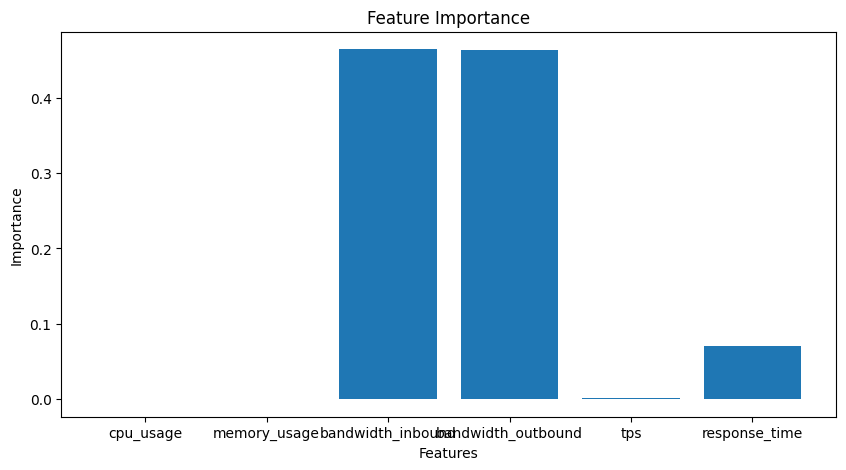

In [34]:
# create model
clf = KerasClassifier(build_fn=create_model, epochs=100, batch_size=32, verbose=0)
clf.fit(X_train, y_train)

# Create a Permutation Importance object
perm = PermutationImportance(clf, random_state=1).fit(X_train, y_train)

# Get feature importances
importances = perm.feature_importances_

print(importances)

# Normalize the importances
normalized_importances = importances / np.sum(importances)

print(normalized_importances)

# Plot the normalized importances
plt.figure(figsize=(10, 5))
plt.bar(feature_cols, normalized_importances)
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

### Train the model

In [28]:
# Import training and testing data
X_test = pickle.load(open("./common/metrics_test.p", "rb"))
X_train = pickle.load(open("./common/metrics_train.p", "rb"))
y_test = pickle.load(open("./common/status_test.p", "rb"))
y_train = pickle.load(open("./common/status_train.p", "rb"))

In [29]:
# Define the model
clf = KerasClassifier(build_fn=create_model, epochs=100, batch_size=32, verbose=0)

# Train the model
clf.fit(X_train, y_train, epochs=150, batch_size=10, verbose=1)

Epoch 1/150


C:\Users\dell\AppData\Local\Temp\ipykernel_18528\3781437085.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  clf = KerasClassifier(build_fn=create_model, epochs=100, batch_size=32, verbose=0)


173/173 [==============================] - 1s 2ms/step - loss: 83.2222
Epoch 2/150
173/173 [==============================] - 0s 2ms/step - loss: 42.3831
Epoch 3/150
173/173 [==============================] - 0s 2ms/step - loss: 33.2223
Epoch 4/150
173/173 [==============================] - 0s 2ms/step - loss: 29.3836
Epoch 5/150
173/173 [==============================] - 0s 2ms/step - loss: 25.8490
Epoch 6/150
173/173 [==============================] - 0s 2ms/step - loss: 24.2045
Epoch 7/150
173/173 [==============================] - 0s 1ms/step - loss: 20.5608
Epoch 8/150
173/173 [==============================] - 0s 2ms/step - loss: 18.3365
Epoch 9/150
173/173 [==============================] - 0s 2ms/step - loss: 15.7287
Epoch 10/150
173/173 [==============================] - 0s 1ms/step - loss: 14.1454
Epoch 11/150
173/173 [==============================] - 0s 2ms/step - loss: 11.6451
Epoch 12/150
173/173 [==============================] - 0s 1ms/step - loss: 8.9037
Epoch 13/150
1

In [30]:
# Use the model to make predictions on the test set
y_pred = clf.predict(X_test)
y_pred = [1 if y >= 0.5 else 0 for y in y_pred]  # threshold

14/14 [==============================] - 0s 2ms/step


In [31]:
# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))

Accuracy: 0.9653579676674365
Precision: 0.8947368421052632
Recall: 0.5666666666666667
F1: 0.6938775510204083


### Visualize the model

In [32]:
clf_matrix = confusion_matrix(y_test, y_pred)
clf_matrix

array([[401,   2],
       [ 13,  17]], dtype=int64)

Text(0.5, 427.9555555555555, 'Predicted Label')

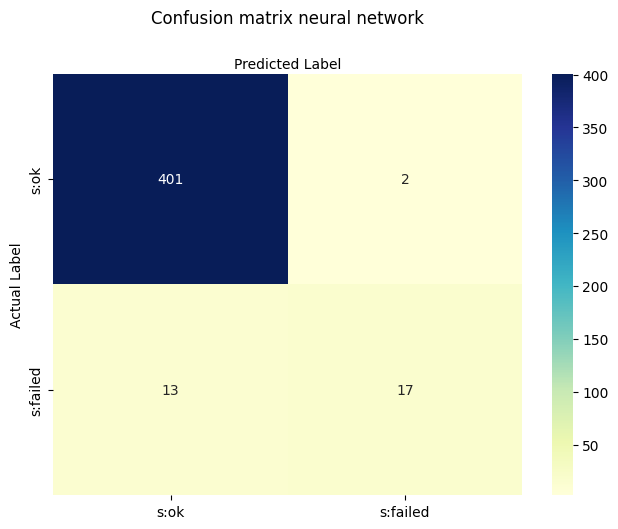

In [33]:
# Assuming clf_matrix is the confusion matrix you've computed
clf_matrix_df = pd.DataFrame(clf_matrix, index=["s:ok", "s:failed"], columns=["s:ok", "s:failed"])

# Create heatmap
class_names=["s:ok", "s:failed"]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))

plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(clf_matrix_df, annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")

plt.tight_layout()
plt.title('Confusion matrix neural network', y=1.1)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')

### Export the model

In [34]:
pickle.dump(clf, open("./models/neural_network.p", "wb"))